In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.utils.data as utils
import torch.nn.functional as F
import torch.optim as optim

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np

import matplotlib.pyplot as plt


In [2]:
# Load the iris dataset
data = load_iris()
X = data['data']
Y = data['target']

X = scale(X, axis=0)
print(X,Y)
print(X.shape,Y.shape)
for i in range(X.shape[1]):
    print(X[:,i].mean(),X[:,i].std())

[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.31544430e

 [ 6.86617933e-02 -1.31979479e-01  7.62758269e-01  7.90670654e-01]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150, 4) (150,)
-1.4684549872375404e-15 1.0
-1.8237263551175904e-15 1.0000000000000004
-1.6105635343895603e-15 0.9999999999999999
-9.473903143468002e-16 1.0


In [3]:
# Split the dataset into training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(96, 4) (24, 4) (30, 4)
(96,) (24,) (30,)


In [4]:
# Create loaders for trainining, test, validation
def create_loader(x,y,batch_size = 8):
    tensor_x = torch.stack([torch.Tensor(i) for i in x]) 
    tensor_y = torch.stack([torch.tensor(np.array(i), dtype=torch.long) for i in y])
    dataset = utils.TensorDataset(tensor_x,tensor_y)
    return dataset, utils.DataLoader(dataset,batch_size = batch_size) 

train_dataset, train_loader = create_loader(X_train,y_train)
val_dataset, val_loader = create_loader(X_val,y_val)
test_dataset, test_loader = create_loader(X_test,y_test)

In [5]:
# Define a very simple model 
class FCNet(torch.nn.Module):
    def __init__(self, layers=[10,10,10]):
        super(FCNet, self).__init__()
        self.l = len(layers)
        self.input = torch.nn.Linear(4, layers[0])
        torch.nn.init.normal_(self.input.weight)
        self.input.bias.data.fill_(0.0)
        
        self.fcs = []
        for i in range(1,len(layers)):
            self.fcs.append(torch.nn.Linear(layers[i-1],layers[i]))
            torch.nn.init.normal_(self.fcs[-1].weight)
            self.fcs[-1].bias.data.fill_(0.0)
        self.list = torch.nn.ModuleList(self.fcs)
            
        self.output = torch.nn.Linear(layers[-1],4)
        torch.nn.init.normal_(self.output.weight)
        self.output.bias.data.fill_(0.0)
        

    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.l-1):
            x = F.relu(self.list[i](x))
        return self.output(x)
    
model = FCNet()
model.to(DEVICE)

FCNet(
  (input): Linear(in_features=4, out_features=10, bias=True)
  (list): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=4, bias=True)
)

In [6]:
# Define an optimiser
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

In [8]:
EPOCHS = 5

train_loss = []
val_loss = []

train_acc = []
val_acc = []

with torch.no_grad():
        t = model(train_dataset.tensors[0])
        v = model(val_dataset.tensors[0])
        t_loss = criterion(t, train_dataset.tensors[1].to(DEVICE))
        v_loss = criterion(v, val_dataset.tensors[1].to(DEVICE))
        train_loss.append(t_loss.item())
        val_loss.append(v_loss.item())
        train_acc.append(accuracy(t.numpy(),train_dataset.tensors[1].numpy()))
        val_acc.append(accuracy(v.numpy(),val_dataset.tensors[1].numpy()))
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
    with torch.no_grad():
        t = model(train_dataset.tensors[0])
        v = model(val_dataset.tensors[0])
        t_loss = criterion(t, train_dataset.tensors[1].to(DEVICE))
        v_loss = criterion(v, val_dataset.tensors[1].to(DEVICE))
        train_loss.append(t_loss.item())
        val_loss.append(v_loss.item())
        train_acc.append(accuracy(t.numpy(),train_dataset.tensors[1].numpy()))
        val_acc.append(accuracy(v.numpy(),val_dataset.tensors[1].numpy()))
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

print('Finished Training')
with torch.no_grad():
    print("Test accuracy: {0:.2f}".format(accuracy(model(test_dataset.tensors[0]).numpy(),test_dataset.tensors[1].numpy())))


Training accuracy: 0.35
Validation accuracy: 0.38
[1,     5] loss: 15.802
[1,    10] loss: 6.887
Training accuracy: 0.68
Validation accuracy: 0.75
[2,     5] loss: 5.733
[2,    10] loss: 2.608
Training accuracy: 0.64
Validation accuracy: 0.67
[3,     5] loss: 2.162
[3,    10] loss: 1.400
Training accuracy: 0.73
Validation accuracy: 0.58
[4,     5] loss: 1.013
[4,    10] loss: 1.022
Training accuracy: 0.75
Validation accuracy: 0.67
[5,     5] loss: 0.715
[5,    10] loss: 0.747
Training accuracy: 0.77
Validation accuracy: 0.75
Finished Training
Test accuracy: 0.73


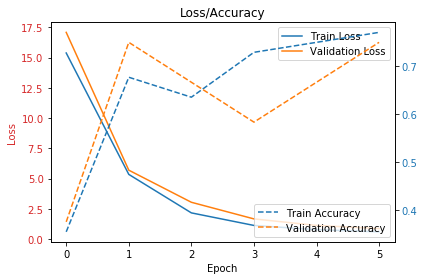

In [9]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Validation Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_acc,linestyle='dashed',label="Train Accuracy")
ax2.plot(val_acc,linestyle='dashed',label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()

plt.title("Loss/Accuracy")
fig.tight_layout()
